In [1]:
import os, sys, glob, shutil, json
import cv2

from PIL import Image
from PIL import ImageChops
from PIL import ImageFilter
import numpy as np
import pandas as pd

from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data.dataset import Dataset
from tensorboardX import SummaryWriter   # tensorboard
import torchvision.transforms as transforms


print(torch.__version__)
print(torch.cuda.is_available())

1.7.0+cu101
True


# 1. 简单获取样本信息

In [2]:
# 统计train, val, test数据集的个数
def data_summary():
    train_list = glob.glob('../input/mchar_train/*.png')
    val_list = glob.glob('../input/mchar_val/*.png')
    test_list = glob.glob('../input/mchar_test_a/*.png')
    print('train image counts: %d' % len(train_list))
    print('val image counts: %d' % len(val_list))
    print('test image counts: %d' % len(test_list))

data_summary()

train image counts: 30000
val image counts: 10000
test image counts: 40000


In [3]:
# 统计图片分别含有数字的个数
def label_summary():
    marks = json.load(open('../input/mchar_train.json', 'r'))

    dicts = {}
    for img, mark in marks.items():
        if len(mark['label']) not in dicts:
            dicts[len(mark['label'])] = 0
        dicts[len(mark['label'])] += 1

    dicts = sorted(dicts.items(), key=lambda x: x[0])
    for k, v in dicts:
        print('%d个数字的图片数目: %d' % (k, v))

label_summary()

1个数字的图片数目: 4636
2个数字的图片数目: 16262
3个数字的图片数目: 7813
4个数字的图片数目: 1280
5个数字的图片数目: 8
6个数字的图片数目: 1


In [4]:
# 看train数据集第一张的信息，长宽高等
def first_photo_info():
    train_json = json.load(open('../input/mchar_train.json'))
    print("First train photo info:")
    print(train_json['000000.png'])

first_photo_info()

First train photo info:
{'height': [219, 219], 'label': [1, 9], 'left': [246, 323], 'top': [77, 81], 'width': [81, 96]}


In [5]:
# 看需要输出文件的信息
def look_submit():
    df = pd.read_csv('../input/mchar_sample_submit_A.csv', sep=',')
    print(df.head(5))

look_submit()

    file_name  file_code
0  000000.png          0
1  000001.png          0
2  000002.png          0
3  000003.png          0
4  000004.png          0


# 2. 训练阶段

下面两个cell中：

只运行第一个cell，不使用训练样本加权；

只运行第二个cell，使用训练样本加权；

### 无训练样本加权

In [6]:
train_path = glob.glob('../input/mchar_train/*.png')
train_path.sort()
train_json = json.load(open('../input/mchar_train.json'))
train_label = [train_json[x]['label'] for x in train_json]

val_path = glob.glob('../input/mchar_val/*.png')
val_path.sort()
val_json = json.load(open('../input/mchar_val.json'))
val_label = [val_json[x]['label'] for x in val_json]

# BATCH_SIZE = 10
BATCH_SIZE = 1000

### 训练样本加权

In [7]:
# 训练集样本加权
# train_json = json.load(open('../input/mchar_train.json'))
# train_label = []
# train_path = []
# for x in train_json:
#     if len(train_json[x]['label']) in [1,2,4]:
#         train_label.append(train_json[x]['label'])
#         train_path.append(os.path.join('../input/mchar_train',x))
#     if len(train_json[x]['label']) in [3]:
#         train_label.append(train_json[x]['label'])
#         train_label.append(train_json[x]['label'])
#         train_path.append(os.path.join('../input/mchar_train',x))
#         train_path.append(os.path.join('../input/mchar_train',x))


# val_path = glob.glob('../input/mchar_val/*.png')
# val_path.sort()
# val_json = json.load(open('../input/mchar_val.json'))
# val_label = [val_json[x]['label'] for x in val_json]

# # BATCH_SIZE = 10
# BATCH_SIZE = 1000

##  2.1 dataset

In [8]:
class SVHNDataset(Dataset):
    def __init__(self, img_path, img_label, transform=None, train=True, test=False):
        self.img_path = img_path
        self.img_label = img_label
        self.train = train
        self.test = test
        if transform is not None:
            self.transform = transform
        else:
            self.transform = None

    def __getitem__(self, index):
        img = Image.open(self.img_path[index]).convert('RGB')
        
        if self.train and not self.test:
            img = img.resize((128, 64))
#             img = ImageChops.offset(img, np.random.randint(-35, 35), np.random.randint(-10, 10))  # 平移
            img = ImageChops.offset(img, np.random.randint(-30, 30), np.random.randint(-20, 20))  # 平移
            if np.random.randint(2):
                img = img.filter(ImageFilter.BLUR)  # 图像模糊

        if self.transform is not None:
            img = self.transform(img)
        
        if self.img_label == None:
            return img
        else:
            # 原始SVHN中类别10为填充的数字X, 最多字符为4
            lbl = np.array(self.img_label[index], dtype=np.int)
            lbl = list(lbl)  + (4 - len(lbl)) * [10]
            return img, torch.from_numpy(np.array(lbl[:4]))

    def __len__(self):
        return len(self.img_path)


train_loader = torch.utils.data.DataLoader(
        SVHNDataset(train_path, train_label,
                   transforms.Compose([
                       transforms.Resize((64, 128)),
                       transforms.RandomCrop((60, 120)),
                       transforms.ColorJitter(0.3, 0.3, 0.2),
                       transforms.RandomRotation(15),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]),train=True, test=False), 
    batch_size=BATCH_SIZE, # 每批样本个数
    shuffle=True, # 是否打乱顺序
    num_workers=10 # 读取的线程个数
)

    
val_loader = torch.utils.data.DataLoader(
    SVHNDataset(val_path, val_label,
                    transforms.Compose([
                        transforms.Resize((60, 120)),
                        transforms.ToTensor(),
                        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]), train=False, test=True), 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    num_workers=10 
)

## 2.2 define model

### baseline model

In [9]:
class SVHN_Model0(nn.Module):
    def __init__(self):
        super(SVHN_Model0, self).__init__()
        # CNN提取特征模块
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(),  
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2)),
            nn.ReLU(), 
            nn.MaxPool2d(2),
        )
        # 
        self.fc1 = nn.Linear(32*3*7, 11)
        self.fc2 = nn.Linear(32*3*7, 11)
        self.fc3 = nn.Linear(32*3*7, 11)
        self.fc4 = nn.Linear(32*3*7, 11)
#         self.fc5 = nn.Linear(32*3*7, 11)
    
    def forward(self, img):        
        feat = self.cnn(img)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
#         c5 = self.fc5(feat)
#         return c1, c2, c3, c4, c5
        return c1, c2, c3, c4

### ResNet34 model

In [10]:
# 定义模型
class SVHN_Model1(nn.Module):
    def __init__(self):
        super(SVHN_Model1, self).__init__()
         # CNN，提取特征
        model_conv = models.resnet34(pretrained=True)
        model_conv.avgpool = nn.AdaptiveAvgPool2d(1)  # 更改了resnet中的avgpool层
        model_conv = nn.Sequential(*list(model_conv.children())[:-1])  # children获得网络的子层，list封装一下，[:-1]遍历全部元素
        self.cnn = model_conv

        # 全连接网络，分类
        self.fc1 = nn.Linear(512, 11)
        self.fc2 = nn.Linear(512, 11)
        self.fc3 = nn.Linear(512, 11)
        self.fc4 = nn.Linear(512, 11)
#         self.fc5 = nn.Linear(512, 11)
    
    def forward(self, img):        
        feat = self.cnn(img)
        feat = feat.view(feat.shape[0], -1)
        c1 = self.fc1(feat)
        c2 = self.fc2(feat)
        c3 = self.fc3(feat)
        c4 = self.fc4(feat)
#         c5 = self.fc5(feat)
#         return c1, c2, c3, c4, c5
        return c1, c2, c3, c4

## 2.3 difine train and validate

In [11]:
def train(train_loader, model, criterion, optimizer, epoch):
    # 切换模型为训练模式
    model.train()
    train_loss = []

    for (data, label) in tqdm(train_loader):
        data = data.cuda()
        label = label.cuda()
#         c0, c1, c2, c3, c4 = model(data)
        c0, c1, c2, c3 = model(data)
          # sample weights
#         loss = 2*criterion(c0, label[:, 0]) + \
#                 criterion(c1, label[:, 1]) + \
#                 2*criterion(c2, label[:, 2]) + \
#                 criterion(c3, label[:, 3])
        
        loss = criterion(c0, label[:, 0]) + \
                criterion(c1, label[:, 1]) + \
                criterion(c2, label[:, 2]) + \
                criterion(c3, label[:, 3])
        
        loss /= (4*BATCH_SIZE)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss.append(loss.item())
    return np.mean(train_loss)


def validate(val_loader, model, criterion):
    # 切换模型为预测模型
    model.eval()
    val_loss = []
    val_predict = []

    # 不记录模型梯度信息
    with torch.no_grad():
        for (data, label) in tqdm(val_loader):
            data = data.cuda()
            label = label.cuda()
            c0, c1, c2, c3 = model(data)
#             c0, c1, c2, c3, c4 = model(data)

            loss = criterion(c0, label[:, 0]) + \
                    criterion(c1, label[:, 1]) + \
                    criterion(c2, label[:, 2]) + \
                    criterion(c3, label[:, 3]) 
            loss /= (4*BATCH_SIZE)
            val_loss.append(loss.item())
            
            # calculate validation accuracy
            output = np.concatenate([
                c0.data.cpu().numpy(),
                c1.data.cpu().numpy(),
                c2.data.cpu().numpy(),
                c3.data.cpu().numpy()], axis=1)  # output: shape(batch, 44)
            val_predict.append(output)        
        val_predict = np.vstack(val_predict)
        
        val_predict = np.vstack([
            val_predict[:, :11].argmax(1),
            val_predict[:, 11:22].argmax(1),
            val_predict[:, 22:33].argmax(1),
            val_predict[:, 33:44].argmax(1)]).T
        val_predict_label = list()
        for x in val_predict:
            val_predict_label.append(''.join(map(str, x[x!=10])))
        val_label = [''.join(map(str, x)) for x in val_loader.dataset.img_label]
        val_acc = np.mean(np.array(val_predict_label) == np.array(val_label))
    return np.mean(val_loss), val_acc

## 2.4 Train model

In [12]:
# load model
# model.load_state_dict(torch.load('model_end.pt'))

torch.manual_seed(0)
torch.backends.cudnn.deterministic = False
torch.backends.cudnn.benchmark = True

model = SVHN_Model1().cuda()
# 损失函数
criterion = nn.CrossEntropyLoss(size_average=False)
# 优化器
optimizer = torch.optim.Adam(model.parameters(), 0.001, weight_decay=0.002)
# optimizer = torch.optim.Adam(model.parameters(), 0.001)
best_loss = 1000.0


train_loss_plot = list()
val_loss_plot = list()
val_acc_plot = list()

# writer = SummaryWriter('log')
writer = SummaryWriter()

from datetime import datetime
now = datetime.now()

for epoch in range(40):
    print('Epoch:', epoch, '/39')
    if epoch == 15: optimizer = torch.optim.Adam(model.parameters(), 0.0001, weight_decay=0.002)
    if epoch == 25: optimizer = torch.optim.Adam(model.parameters(), 0.00001, weight_decay=0.002)
#     if epoch == 35: optimizer = torch.optim.Adam(model.parameters(), 0.00001, weight_decay=0.0005)

    train_loss = train(train_loader, model, criterion, optimizer, epoch)
    val_loss, val_acc = validate(val_loader, model, criterion)# val_predict: shape(10000, 44)

    
    # 记录下验证集精度
    if val_loss < best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(), './model_best.pt')
    
    train_loss_plot.append(train_loss)
    val_loss_plot.append(val_loss)
    val_acc_plot.append(val_acc)
    writer.add_scalar('Loss/train', float(train_loss), epoch)
    writer.add_scalar('Loss/validation', float(val_loss), epoch)
    writer.add_scalar('val_acc', float(val_acc), epoch)

writer.close()
torch.save(model.state_dict(), './model_end.pt')

print("\nruning time:", datetime.now() - now)

/usr/local/anaconda3/envs/py36/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 0 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 2 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 3 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 4 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 5 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 6 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 7 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 8 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 9 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 10 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 11 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 12 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 13 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 14 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 15 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 16 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 17 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 18 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 19 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 20 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 21 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 22 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 23 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 24 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 25 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 26 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 27 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 28 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 29 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 30 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 31 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 32 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 33 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 34 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 35 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 36 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 37 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 38 /39


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 39 /39


100%|██████████| 10/10 [00:02<00:00,  3.35it/s]



runing time: 0:09:04.509833


## 2.5 Plot loss and accuracy

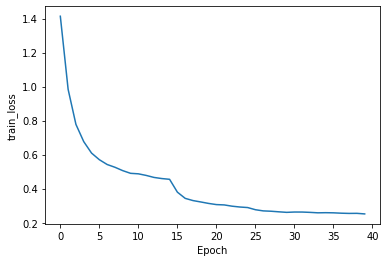

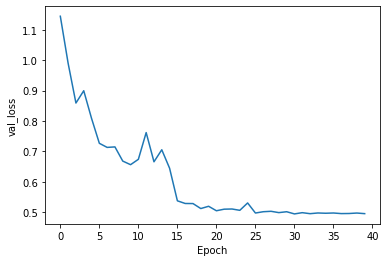

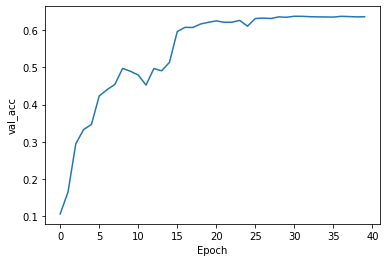


train_loss: [1.413496239980062, 0.9836617588996888, 0.7777472376823426, 0.6763895253340403, 0.6090225120385487, 0.5701543033123017, 0.5419283787409465, 0.5256408890088399, 0.5057778159777323, 0.4900642017523448, 0.4871473322312037, 0.4777562459309896, 0.4659560312827428, 0.45932700832684836, 0.45491883158683777, 0.3793445994456609, 0.3429139713446299, 0.32986054122447966, 0.32169615228970844, 0.3130987038215001, 0.30625282824039457, 0.30431928634643557, 0.29694238205750784, 0.2920198947191238, 0.2889046827952067, 0.2761162141958872, 0.26922240952650706, 0.2672285174330076, 0.26376947859923044, 0.26063103079795835, 0.2624988953272502, 0.26239150365193686, 0.260493078827858, 0.25790369510650635, 0.2586543336510658, 0.25787331312894823, 0.2556500459710757, 0.2544091204802195, 0.2548128937681516, 0.2514434819420179] 

max: 1.413496239980062

val_loss: [1.1448170304298402, 0.9898936569690704, 0.858983725309372, 0.8995077252388001, 0.808467423915863, 0.7263594806194306, 0.7128963589668273, 

In [13]:
plt.plot(train_loss_plot)
plt.xlabel("Epoch")
plt.ylabel("train_loss")
plt.show()

plt.plot(val_loss_plot)
plt.xlabel("Epoch")
plt.ylabel("val_loss")
plt.show()

plt.plot(val_acc_plot)
plt.xlabel("Epoch")
plt.ylabel("val_acc")
plt.show()

print("\ntrain_loss:", train_loss_plot, "\n\nmax:", max(train_loss_plot))
print("\nval_loss:", val_loss_plot, "\n\nmax:", max(val_loss_plot))
print("\nval_acc:", val_acc_plot, "\n\nmax:", max(val_acc_plot))

# 3. 测试阶段

## 3.1 Test dataset and predict

In [14]:
test_path = glob.glob('../input/mchar_test_a/*.png')
test_path.sort()
test_label = None


test_loader = torch.utils.data.DataLoader(
        SVHNDataset(test_path, test_label,
                   transforms.Compose([
                       transforms.Resize((60, 120)),
                       transforms.ToTensor(),
                       transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]), train=False, test=True), 
    batch_size=BATCH_SIZE, # 每批样本个数
    shuffle=False, # 是否打乱顺序
    num_workers=10, # 读取的线程个数
)


def predict(test_loader, model):
    model.eval()

    test_pred = []
    with torch.no_grad():
        for input in tqdm(test_loader):
            input = input.cuda()

            c0, c1, c2, c3 = model(input)
            output = np.concatenate([
                c0.data.cpu().numpy(),
                c1.data.cpu().numpy(),
                c2.data.cpu().numpy(),
                c3.data.cpu().numpy()], axis = 1)
            test_pred.append(output)
        test_pred = np.vstack(test_pred)
        test_pred = np.vstack([
            test_pred[:, :11].argmax(1),
            test_pred[:, 11:22].argmax(1),
            test_pred[:, 22:33].argmax(1),
            test_pred[:, 33:44].argmax(1)]).T
        
        test_predict_label = list()        
        for x in test_pred:
            test_predict_label.append(''.join(map(str, x[x!=10])))
    return test_predict_label


# load model
model.load_state_dict(torch.load('model_best.pt'))
submit = predict(test_loader, model)

100%|██████████| 40/40 [00:05<00:00,  6.86it/s]


## 3.2 写入csv文件

In [15]:
df_submit = pd.read_csv('../input/mchar_sample_submit_A.csv')
df_submit['file_code'] = submit
df_submit.to_csv('submit.csv', index=None)
print("save success!")

save success!
